In [6]:
from __future__ import division, print_function, absolute_import

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, TensorBoard

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [18]:
# Hyper Parameter
batch_size = 86
epochs = 30

In [8]:
# Set up TensorBoard
tensorboard = TensorBoard(batch_size=batch_size)

with h5py.File("./3d-mnist-kaggle/full_dataset_vectors.h5", 'r') as h5:
    X_train, y_train = h5["X_train"][:], h5["y_train"][:]
    X_test, y_test = h5["X_test"][:], h5["y_test"][:]


In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10000, 4096), (10000,), (2000, 4096), (2000,))

In [11]:
y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

X_train = X_train.reshape(-1, 16, 16, 16)
X_test  = X_test.reshape(-1, 16, 16, 16)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8500, 16, 16, 16),
 (8500, 10),
 (1500, 16, 16, 16),
 (1500, 10),
 (2000, 16, 16, 16),
 (2000,))

In [14]:
# Conv2D layer
def Conv(filters=16, kernel_size=(3,3), activation='relu', input_shape=None):
    if input_shape:
        return Conv2D(filters=filters, kernel_size=kernel_size, padding='Same', activation=activation, input_shape=input_shape)
    else:
        return Conv2D(filters=filters, kernel_size=kernel_size, padding='Same', activation=activation)


# Define Model
def CNN(input_dim, num_classes):
    model = Sequential()

    model.add(Conv(8, (3,3), input_shape=input_dim))
    model.add(Conv(16, (3,3)))
    # model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv(32, (3,3)))
    model.add(Conv(64, (3,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Train Model
def train(optimizer, scheduler, gen):
    global model

    print("Training...")
    model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    model.fit_generator(gen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_val, y_val),
                    verbose=2, steps_per_epoch=X_train.shape[0]//batch_size,
                    callbacks=[scheduler, tensorboard])
def evaluate():
    global model

    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    print(accuracy_score(pred,y_test))
    # Heat Map
    array = confusion_matrix(y_test, pred)
    cm = pd.DataFrame(array, index = range(10), columns = range(10))
    plt.figure(figsize=(20,20))
    sns.heatmap(cm, annot=True)
    plt.show()

def save_model():
    global model

    model_json = model.to_json()
    with open('model/model_2D.json', 'w') as f:
        f.write(model_json)

    model.save_weights('model/model_2D.h5')

    print('Model Saved.')

def load_model():
    f = open('model/model_2D.json', 'r')
    model_json = f.read()
    f.close()

    loaded_model = model_from_json(model_json)
    loaded_model.load_weights('model/model_2D.h5')

    print("Model Loaded.")
    return loaded_model


C:\Users\Isaac\Documents\miniconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1183: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8500, 16, 16, 16) (16 channels).
  ' channels).')


Training...


C:\Users\Isaac\Documents\miniconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1404: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8500, 16, 16, 16) (16 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/30
 - 10s - loss: 2.0765 - acc: 0.2853 - val_loss: 1.3734 - val_acc: 0.4960
Epoch 2/30
 - 9s - loss: 1.4759 - acc: 0.4768 - val_loss: 1.1494 - val_acc: 0.6093
Epoch 3/30
 - 9s - loss: 1.2973 - acc: 0.5379 - val_loss: 1.1178 - val_acc: 0.5967
Epoch 4/30
 - 10s - loss: 1.2355 - acc: 0.5636 - val_loss: 1.0950 - val_acc: 0.6087
Epoch 5/30
 - 10s - loss: 1.1721 - acc: 0.5836 - val_loss: 1.0397 - val_acc: 0.6113
Epoch 6/30
 - 9s - loss: 1.1574 - acc: 0.5875 - val_loss: 1.0263 - val_acc: 0.6120
Epoch 7/30
 - 9s - loss: 1.1334 - acc: 0.5975 - val_loss: 1.0322 - val_acc: 0.6147
Epoch 8/30
 - 10s - loss: 1.1138 - acc: 0.6024 - val_loss: 0.9909 - val_acc: 0.6427
Epoch 9/30
 - 10s - loss: 1.0947 - acc: 0.6126 - val_loss: 1.1797 - val_acc: 0.6020
Epoch 10/30
 - 10s - loss: 1.0744 - acc: 0.6145 - val_loss: 0.9982 - val_acc: 0.6467
Epoch 11/30
 - 10s - loss: 1.0447 - acc: 0.6307 - val_loss: 0.9332 - val_acc: 0.6647
Epoch 12/30
 - 10s - loss: 1.0610 - acc: 0.6224 - val_loss: 0.9514 - val_acc: 

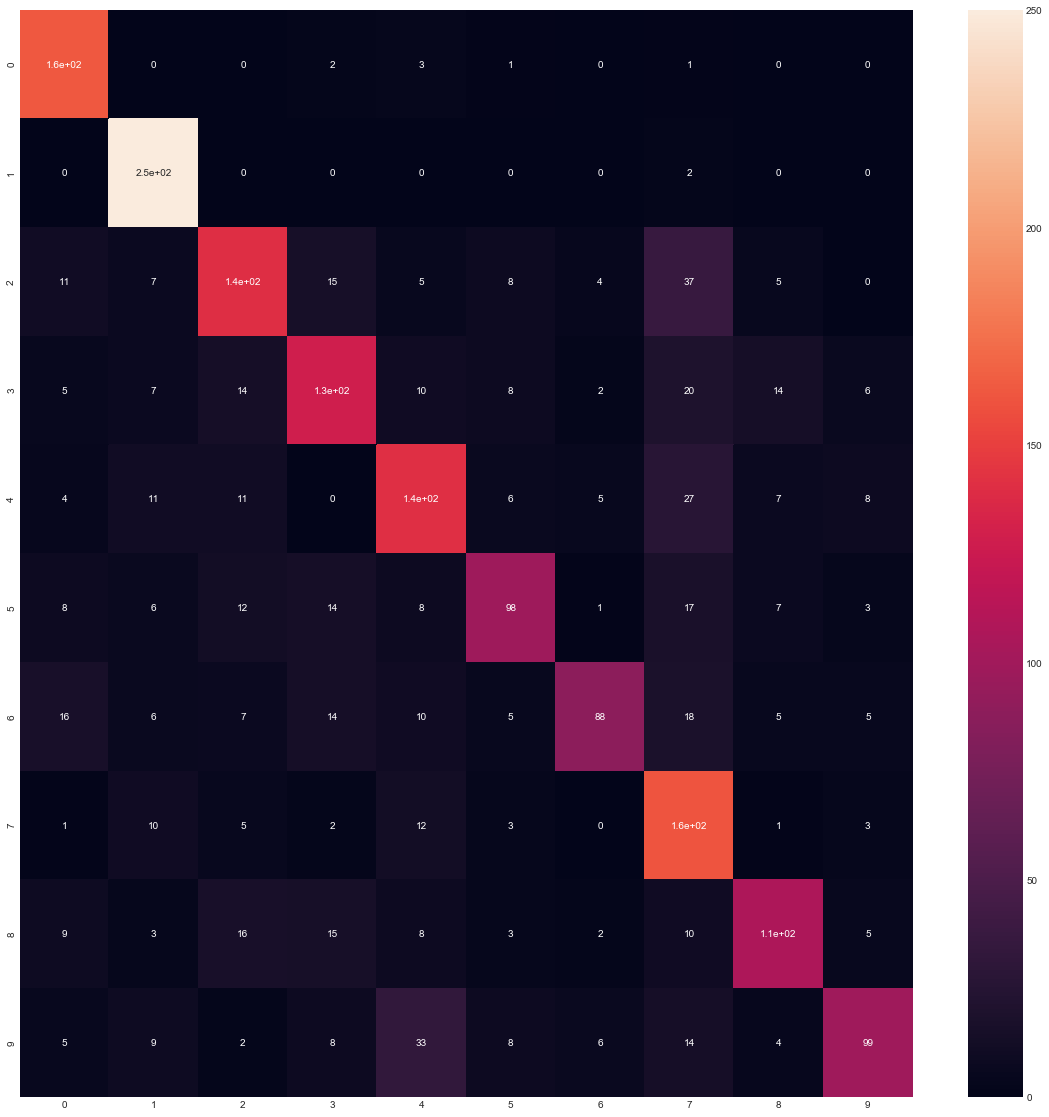

Model Saved.


In [19]:
if __name__ == '__main__':

    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    scheduler = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

    model = CNN((16,16,16), 10)

    gen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)
    gen.fit(X_train)
    
#     model = load_model()
    train(optimizer, scheduler, gen)
    evaluate()
    save_model()
